<a id='startpage'></a>

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Очистка-текстовых-данных" data-toc-modified-id="Очистка-текстовых-данных-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Очистка текстовых данных</a></span></li><li><span><a href="#SpaCy-лематтизация" data-toc-modified-id="SpaCy-лематтизация-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>SpaCy лематтизация</a></span></li><li><span><a href="#Деление-на-обучающую-и-тестовую-выборки" data-toc-modified-id="Деление-на-обучающую-и-тестовую-выборки-1.0.3"><span class="toc-item-num">1.0.3&nbsp;&nbsp;</span>Деление на обучающую и тестовую выборки</a></span></li><li><span><a href="#Масштабирование-данных-с-помощью-TF-IDF" data-toc-modified-id="Масштабирование-данных-с-помощью-TF-IDF-1.0.4"><span class="toc-item-num">1.0.4&nbsp;&nbsp;</span>Масштабирование данных с помощью TF-IDF</a></span></li></ul></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#SGD-Classifier" data-toc-modified-id="SGD-Classifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>SGD Classifier</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#SGD-Classifier" data-toc-modified-id="SGD-Classifier-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>SGD Classifier</a></span></li></ul></li><li><span><a href="#Сравнение-результатов" data-toc-modified-id="Сравнение-результатов-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Сравнение результатов</a></span><ul class="toc-item"><li><span><a href="#Confusion-Matrix" data-toc-modified-id="Confusion-Matrix-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Confusion Matrix</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Задача:**
- Обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

- Построить модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<div class="alert alert-info"> 
    В работе использована литература:
    
- Мюллер Андреас, Гвидо Сара. Введение в машинное обучение с помощью Python, 2017.

- Sebastian Raschka. Python Machine Learning: Packt PuЬlishing, 2020

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display

import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from sklearn.linear_model import LogisticRegression, SGDClassifier
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool, cv

from numpy.random import RandomState
rdm = RandomState(12345)

import nltk
from nltk.corpus import stopwords as stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

import matplotlib.pyplot as plt
import seaborn as sns

# Install spaCy (run in terminal/prompt)
import sys
!{sys.executable} -m pip install spacy
# Download spaCy's  'en' Model
!{sys.executable} -m spacy download en
import spacy

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     |████████████████████████████████| 13.9 MB 2.3 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
df = pd.read_csv('/datasets/toxic_comments.csv')
display(df.sample(3))
print(df.info())
print('\nУникальные значения "toxic": ', df['toxic'].unique())
print('Количество дубликатов: ', df.duplicated().sum())

,text,toxic
78844,"""\nI'm not sure on this one, and I don't reall...",0
111816,Andy Stasny is a fag and likes penis,1
2142,"""\n\n Scorched earth. \n\nIf I'm wrong, I apol...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None

Уникальные значения "toxic":  [0 1]
Количество дубликатов:  0


Пропусков и дубликатов нет.

Посмотрим на баланс классов в целевом признаке.

In [4]:
df['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

Токсичных отзывов с категорией 1 - 10%. Классы не сбалансированы.

В исходных данных около 160 тысяч комментариев, примерно 10% из которых - "токсичные".

#### Очистка текстовых данных

Сделаем предобработку текста.

In [5]:
print("df['text'][22]:\n{}".format(df['text'][22]))

df['text'][22]:
"

 Snowflakes are NOT always symmetrical! 

Under Geometry it is stated that ""A snowflake always has six symmetric arms."" This assertion is simply not true! According to Kenneth Libbrecht, ""The rather unattractive irregular crystals are by far the most common variety."" http://www.its.caltech.edu/~atomic/snowcrystals/myths/myths.htm#perfection Someone really need to take a look at his site and get FACTS off of it because I still see a decent number of falsities on this page. (forgive me Im new at this and dont want to edit anything)"


Как мы видим, столбец `text` представлен комментариями на английском языке, текст может содержать ссылки, разметку HTML, пунктуацию и другие небуквенные символы.
Удалим все знаки препинания, сохранив символы эмоций (эмограммы), поскольку они дают эмоциональную окраску комментариев.

Воспользуемся библиотекой регулярных выражений `Python ге` и функцией.

In [6]:
def preprocessor(text):
    text = re.sub('>[^>]*>', '', text) # удаление разметки HTML
    text = re.sub('http://\S+|https://\S+', '', text) # удаление ссылок
    emogramms = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text) # эмограммы
    text = re.sub('[\W]+', ' ', text.lower())+\
    ' '.join(emogramms).replace ('-', '') # удаление несловарных символов, включение эмограмм, приведение к нижнему регистру 
    return text

In [7]:
df['clear_text'] = df['text'].apply(preprocessor)

In [8]:
print("df['clear_text'][22]:\n{}".format(df['clear_text'][22]))

df['clear_text'][22]:
 snowflakes are not always symmetrical under geometry it is stated that a snowflake always has six symmetric arms this assertion is simply not true according to kenneth libbrecht the rather unattractive irregular crystals are by far the most common variety someone really need to take a look at his site and get facts off of it because i still see a decent number of falsities on this page forgive me im new at this and dont want to edit anything 


#### SpaCy лематтизация

`SpaCy` по умолчанию определяет часть речи и назначает соответствующую лемму.

Напишем функцию lemmatize(text). На вход она принимает текст из корпуса и возвращает лемматизированную строку.

In [9]:
%time

nlp = spacy.load('en_core_web_sm') # вариант: ('en', disable=['parser', 'ner'])
def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])
df['clear_text'] = df['clear_text'].apply(lemmatize)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


In [10]:
df.sample(2)

,text,toxic,clear_text
109563,"""::: Well then - we can always put in """"used i...",0,well then we can always put in use in offici...
722,Don't peddle your crap please. Hate to see an...,1,don t peddle your crap please hate to see anot...


#### Деление на обучающую и тестовую выборки

Разобьем данные на обучающую и тестовую выборки перед использованием метода `TF-IDF`.

In [11]:
X = df['clear_text']
y= df['toxic']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rdm)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(111699,)
(111699,)
(47872,)
(47872,)


#### Масштабирование данных с помощью TF-IDF

In [13]:
count_tf_idf = TfidfVectorizer(min_df=5, stop_words=stopwords)
count_tf_idf.fit(X_train)

TfidfVectorizer(min_df=5,
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...})

In [14]:
X_train_tf_idf = count_tf_idf.transform(X_train)
X_test_tf_idf = count_tf_idf.transform(X_test)

In [15]:
X_train_tf_idf

<111699x23404 sparse matrix of type '<class 'numpy.float64'>'
	with 2834631 stored elements in Compressed Sparse Row format>

Посмотрим, какие слова в результате преобразования tf-idf стали наиболее и наименее важными. 

In [16]:
max_value = X_train_tf_idf.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# получаем имена признаков
feature_names = np.array(count_tf_idf.get_feature_names())
 
print("Признаки с наименьшими значениями tfidf:\n{}".format(
 feature_names[sorted_by_tfidf[:20]]))
 
print("Признаки с наибольшими значениями tfidf: \n{}".format(
 feature_names[sorted_by_tfidf[-20:]]))

Признаки с наименьшими значениями tfidf:
['hakenkreuz' 'newl' 'garter' 'gumbel' 'naidu' 'venkaiah' '27510'
 'reserache' 'twirl' 'assuredly' 'cedff2' 'cleavage' 'citeref' 'reftest'
 '37169' 'simpleref' 'footown' 'namedref' 'elizium23' 'tekleni']
Признаки с наибольшими значениями tfidf: 
['poor' 'poop' 'hello' 'wikipedia' 'rabbi' 'expose' 'marry' 'sing' 'smell'
 'right' 'help' 'explain' 'situation' 'policy' 'exept' 'try' 'exception'
 'usa' 'candidacy' 'wiki']


Как мы видим, «важное» не обязательно должно быть связано с интересующими нас метками «положительный коммент» или «токсичный коммент». 
Эти слова вряд ли помогут нам в классификации тональности комментариев, тем не менее они содержат много конкретной информации.

Посмотрим на слова, которые имеют низкое значение обратной частоты документа, то есть слова, которые встречаются часто и поэтому считаются менее важными.

In [17]:
sorted_by_idf = np.argsort(count_tf_idf.idf_)
print("Признаки с наименьшими значениями idf:\n{}".format(feature_names[sorted_by_idf[:200]]))

Признаки с наименьшими значениями idf:
['article' 'page' 'talk' 'wikipedia' 'edit' 'make' 'please' 'one' 'like'
 'would' 'see' 'use' 'thank' 'think' 'know' 'say' 'go' 'also' 'get' 'well'
 'time' 'add' 'source' 'good' 'people' 'need' 'take' 'want' 'look' 'find'
 'remove' 'may' 'user' 'even' 'work' 'delete' 'block' 'way' 'could' 'give'
 'comment' 'try' 'link' 'name' 'thing' 'change' 'write' 'point'
 'information' 'first' 'seem' 'read' 'help' 'much' 'fact' 'new' 'editor'
 'right' 'section' 'list' 'really' 'come' 'question' 'discussion' 'many'
 'place' 'mean' 'since' 'revert' 'include' 'wp' 'back' 'reference' 'ask'
 'someone' 'reason' 'call' 'still' 'stop' 'consider' 'leave' 'note' 'two'
 'create' 'put' 'something' 'show' 'state' 'keep' 'utc' 'issue' 'without'
 'feel' 'let' 'post' 'year' 'case' 'another' 'mention' 'problem' 'sure'
 'believe' 'might' 'content' 'policy' 'word' 'however' 'long' 'start'
 'day' 'person' 'claim' 'request' 'part' 'never' 'tell' 'deletion'
 'history' 'anything' 'a

## Обучение моделей

В нашем исследовании обучим следующие линейные модели, как наиболее оптимальные (скорость-качество) при работе с текстами:
- LogisticRegression
- SGD Classifier

### LogisticRegression

In [18]:
%time

param_grid_lg = {'C': [0.01, 0.1, 1, 10]}
lg = LogisticRegression(random_state=12345, class_weight='balance')
grid_search_lg = GridSearchCV(estimator=lg, param_grid=param_grid_lg, scoring='f1', 
                              cv=5, n_jobs=-1, verbose=2)
grid_search_lg.fit(X_train_tf_idf, y_train)
print("F1 лучшей модели LogisticRegression:", (grid_search_lg.best_score_).round(4),
      "\nЛучшая модель:", grid_search_lg.best_params_)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .............................................C=0.01; total time=   3.3s
[CV] END .............................................C=0.01; total time=   3.7s
[CV] END .............................................C=0.01; total time=   3.4s
[CV] END .............................................C=0.01; total time=   3.7s
[CV] END .............................................C=0.01; total time=   3.2s
[CV] END ..............................................C=0.1; total time=  14.0s
[CV] END ..............................................C=0.1; total time=  10.2s
[CV] END ..............................................C=0.1; total time=  12.2s
[CV] END ..............................................C=0.1; total time=  14.0s
[CV] END ..............................................C=0.1; total time=  11.9s
[CV] END ................................................C=1; tota

F1 лучшей модели LogisticRegression: 0.7733 (с class_weight='balance')


F1 лучшей модели LogisticRegression: 0.7765

Лучшая модель: {'C': 10}

### SGD Classifier

In [19]:
%time

param_grid_sgd = {
    "alpha" : [1e-02, 1e-03, 1e-04, 1e-05, 1e-06],
    "penalty" : ["l2", "l1"]
}
sgd = SGDClassifier(random_state=12345, loss="log")
grid_search_sgd = GridSearchCV(estimator=sgd, param_grid=param_grid_sgd, scoring='f1', 
                              cv=5, n_jobs=-1, verbose=2)
grid_search_sgd.fit(X_train_tf_idf, y_train)
print("F1 лучшей модели SGDClassifier:", (grid_search_sgd.best_score_).round(4),
      "\nЛучшая модель:", grid_search_sgd.best_params_)

CPU times: user 17 µs, sys: 2 µs, total: 19 µs
Wall time: 6.68 µs
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .............................alpha=0.01, penalty=l2; total time=   0.5s
[CV] END .............................alpha=0.01, penalty=l2; total time=   0.5s
[CV] END .............................alpha=0.01, penalty=l2; total time=   0.4s
[CV] END .............................alpha=0.01, penalty=l2; total time=   0.4s
[CV] END .............................alpha=0.01, penalty=l2; total time=   0.5s
[CV] END .............................alpha=0.01, penalty=l1; total time=   0.5s
[CV] END .............................alpha=0.01, penalty=l1; total time=   0.5s
[CV] END .............................alpha=0.01, penalty=l1; total time=   0.5s
[CV] END .............................alpha=0.01, penalty=l1; total time=   0.5s
[CV] END .............................alpha=0.01, penalty=l1; total time=   0.5s
[CV] END ............................alpha=0.001, penalty=l2; t

F1 лучшей модели SGDClassifier: 0.777

Лучшая модель: {'alpha': 1e-06, 'penalty': 'l2'}

## Тестирование

### LogisticRegression

In [26]:
%%time

# Лучшая модель: {'C': 10}
lg_best = LogisticRegression(C=10, random_state=12345, class_weight='balance')
lg_best.fit(X_train_tf_idf, y_train)

target_predict_lg = lg_best.predict(X_test_tf_idf)

# F1 лучшей модели LinearRegression на обучающей выборке: 0.7765
f1_lg_best_test = f1_score(y_test, target_predict_lg)
print("F1 LogisticRegression на тестовой выборке:", f1_lg_best_test.round(4))

F1 LogisticRegression на тестовой выборке: 0.7889
CPU times: user 7.59 s, sys: 18.6 s, total: 26.2 s
Wall time: 26.2 s


F1 LogisticRegression на тестовой выборке: 0.7889 (с class_weight='balance')


F1 LogisticRegression на тестовой выборке: 0.7752

CPU times: user 7.28 s, sys: 20.3 s, total: 27.6 s

Wall time: 27.7 s

### SGD Classifier

In [21]:
%%time

# Лучшая модель: {'alpha': 1e-06, 'penalty': 'l2'}
sgd_best = SGDClassifier(alpha=1e-06, penalty='l2', random_state=12345, loss="log")
sgd_best.fit(X_train_tf_idf, y_train)

target_predict_sgd = sgd_best.predict(X_test_tf_idf)

# F1 лучшей модели SGDClassifier на обучающей выборке: 0.777
f1_sgd_best_test = f1_score(y_test, target_predict_lg)
print("F1 SGDClassifier на тестовой выборке:", f1_sgd_best_test.round(4))

F1 SGDClassifier на тестовой выборке: 0.7889
CPU times: user 535 ms, sys: 106 ms, total: 641 ms
Wall time: 652 ms


F1 SGDClassifier на тестовой выборке: 0.7752

CPU times: user 546 ms, sys: 120 ms, total: 665 ms

Wall time: 621 ms

## Сравнение результатов

### Confusion Matrix

Для визуализации качества предсказания моделей обратимся к `Confusion Matrix`. Используем функцию.

In [22]:
def model_conf_matrix(model, feature, target):

    pred = model.predict(feature)
    conf_matrix = confusion_matrix(target, pred)
    
    print('F1_score = {:.3}'.format(f1_score(target, pred)))
    
    plt.figure(figsize=(4,4))
    sns.heatmap(conf_matrix, annot=True, cmap="Oranges", cbar=False, fmt="d")
    plt.title('Confusion Matrix');

LogisticRegression, тестовая выборка
F1_score = 0.789


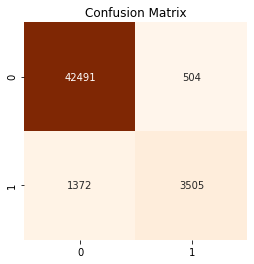

In [23]:
print('LogisticRegression, тестовая выборка')
model_conf_matrix(lg_best, X_test_tf_idf, y_test)

SGDClassifier, тестовая выборка
F1_score = 0.788


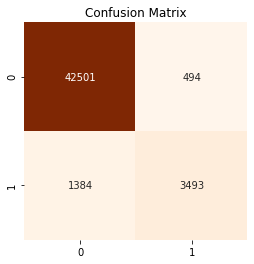

In [24]:
print('SGDClassifier, тестовая выборка')
model_conf_matrix(sgd_best, X_test_tf_idf, y_test)

Поскольку в нашем исследовании стоит задача выявления токсичных комментариев, то SGDClassifier показывает чуть лучшие результаты по сравнению с LogisticRegression: TN выше, и ошибка второго рода меньше, однако ошибка первого рода выше.

Суммарно ошибки составляют около 4% от предсказанных значений на тестовой выборке.

Занесем данные в итоговую сравнительную таблицу.

In [25]:
index = ['LogisticRegression',
         'SGDClassifier']
data = {'F1 модели на обучающей выборке':[0.7765, 
                                          0.777],
        'F1 модели на тестовой выборке':[0.7752,
                                         0.7752]}

summary = pd.DataFrame(data=data, index=index)
summary

,F1 модели на обучающей выборке,F1 модели на тестовой выборке
LogisticRegression,0.7765,0.7752
SGDClassifier,0.7770,0.7752


## Выводы

**Вывод:** 

Обе линейные модели `LogisticRegression` и `SGDClassifier` показали хорошие результаты при работе с нашими текстовыми данными, показав одинаковый F1 на тестовой выборке, равный 0.7752. Учитывая результаты, полученные на `Confusion Matrix`, лучшей моделью выберем `SGDClassifier` с подобранными гиперпараметрами: 'alpha': 1e-06, 'penalty': 'l2'.

Вернуться в [начало](#startpage).